In [62]:
import pickle
import os
import sys
from statistics import mean
from typing import List
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
working_dir = os.getcwd()
os.chdir("../../..")
sys.path.append(os.getcwd())
from Internal_Representation.state import State
from Solver.action_tracker import ActionTracker
from runner import Runner
os.chdir(working_dir)

In [2]:
os.getcwd()

'C:\\Users\\Cael\\Documents\\University\\4th year\\Dissertation\\4th-Year-Dissertation\\Tests\\Evaluation\\Heuristic_Evaluation'

In [3]:
# Load pickled Object
def load_pickled_ob(file_name):
    with (open(file_name, "rb")) as openfile:
        while True:
            try:
                return pickle.load(openfile)
            except EOFError:
                break

In [4]:
# Display pickled actions_taken
def display_actions_taken(actions):
    for a in actions:
        print(a)

In [5]:
# Display pickled final state
def display_final_state(final_state):
    print(final_state)

In [6]:
size_dict = load_pickled_ob("problem_sizes.pickle")
size_dict

{'Basic/pb1.hddl': 46,
 'Rover/p01.hddl': 483,
 'Rover/p02.hddl': 486,
 'Rover/p03.hddl': 501,
 'Rover/p04.hddl': 554,
 'Rover/p05.hddl': 633,
 'Rover/p06.hddl': 648,
 'Rover/p07.hddl': 724}

In [7]:
class average_time:
    def __init__(self):
        self.times = {} # {'roverp0': float}
        self.num_models = {}    # {'roverp0': float}

    def calculate_average_time(self, problem_name: str, times: list) -> None:
        self.times[problem_name] = mean(times)

    def calculate_average_model(self, problem_name: str, num_models: list) -> None:
        self.num_models[problem_name] = mean(num_models)

    def get_num_models(self, problem_name: str) -> float:
        return self.num_models[problem_name]

    def __getitem__(self, item):
        return self.times[item]

In [39]:
def generate_graph(example_names: list, config_names: list, colours: list, values: list,
                   title="Average Time Taken for Solving", y_axis="Average Time Taken (Seconds)"):
    assert len(config_names) == len(colours) == len(values)
    assert all([len(x) == len(example_names) for x in values])
    plt.figure(figsize=(18, 8))

    print(values)
    x_values = [size_dict[x] for x in example_names]

    i, l = 0, len(config_names)
    while i < l:
        y_values = [values[i][y] for y in range(len(values[i]))]
        plt.plot(x_values, y_values, 'bo-', label=r'{}'.format(config_names[i]), color=colours[i], alpha=0.6, linewidth=3)
        i += 1
    plt.xticks(x_values, [str(x) for x in x_values])
    plt.locator_params(axis='x', nbins=len(example_names))
    plt.xlabel('Problem Size'); plt.ylabel(r'{}'.format(y_axis))
    plt.title(r'{}'.format(title))
    plt.legend(loc='best')
    # plt.savefig("{}_ABS_features_Weight_plot.svg".format('lasso - Ridge'), dpi=500)  # Save graph to file
    plt.grid()

In [79]:
from scipy.stats import shapiro
from scipy.stats import kruskal
from scipy.stats import ttest_ind
def significant_difference_check(list_approach_names: List[str], *args):
    """Check for statistically different data sets"""
    assert len(list_approach_names) == len(args)

    # Run shapiro test on all data
    data_values = [shapiro(x)[1] for x in args]
    data_normal = [x < 0.05 for x in data_values]

    # Run ANOVA or Kruskal test
    if all(x == False for x in data_normal):
        # Anova test
        print("All data is normally distributed")
        print("Shapiro p-values:", data_values)
        print("Non-Normal Check (False denoted non-normal):", data_normal)

        if len(list_approach_names) >= 3:
            # One-way ANOVA
            # https://www.scribbr.com/statistics/two-way-anova/#:~:text=ANOVA%20(Analysis%20of%20Variance)%20is,levels%20of%20two%20categorical%20variables.
            raise NotImplementedError
        else:
            # https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html
            assert len(list_approach_names) == 2
            res = ttest_ind(args[0], args[1])[1]
            if res < 0.05:
                # There is significant difference
                print()
                raise NotImplementedError
            else:
                # No significant difference
                print()
                raise NotImplementedError
    else:
        # Kruskals test
        print("NOT FOLLOWING NORMAL DISTRIBUTION")
        print("Shapiro p-values:", data_values)
        print("Non-Normal Check (False denotes non-normal):", data_normal)
        raise NotImplementedError

    # Run Dunn Test

# Running operations on collected Data

## Rover p0 -> p3 with early precondition checking and without

In [9]:
"""Load data from breadth first - no early precondition checker"""
breadth_first_no_early_precon_check_data_path = os.path.join(os.getcwd(), "Archive", "rover_no_early_precon", "Breadth_First_Operations.csv")
breadth_first_no_early_precon_check = pd.read_csv(breadth_first_no_early_precon_check_data_path, sep=",")

breadth_first_no_early_precon_check_av_time = average_time()
for example_name in breadth_first_no_early_precon_check.example_name.unique():

    breadth_first_no_early_precon_check_av_time.calculate_average_time(example_name, breadth_first_no_early_precon_check[breadth_first_no_early_precon_check['example_name'] == example_name]['time_taken'])

    breadth_first_no_early_precon_check_av_time.calculate_average_model(example_name,                               breadth_first_no_early_precon_check[breadth_first_no_early_precon_check['example_name'] == example_name]['search_models_created'])

breadth_first_no_early_precon_check

,example_name,time_taken,search_models_created,serialised_actions_taken,serialised_state
0,Rover/p01.hddl,0.401264,1391,serialised_objects\Rover_p01hddl_Breadth_First...,serialised_objects\Rover_p01hddl_Breadth_First...
1,Rover/p01.hddl,0.489056,2782,serialised_objects\Rover_p01hddl_Breadth_First...,serialised_objects\Rover_p01hddl_Breadth_First...
2,Rover/p01.hddl,0.427552,4173,serialised_objects\Rover_p01hddl_Breadth_First...,serialised_objects\Rover_p01hddl_Breadth_First...
3,Rover/p01.hddl,0.426063,5564,serialised_objects\Rover_p01hddl_Breadth_First...,serialised_objects\Rover_p01hddl_Breadth_First...
4,Rover/p01.hddl,0.433008,6955,serialised_objects\Rover_p01hddl_Breadth_First...,serialised_objects\Rover_p01hddl_Breadth_First...
5,Rover/p02.hddl,1.011344,9502,serialised_objects\Rover_p02hddl_Breadth_First...,serialised_objects\Rover_p02hddl_Breadth_First...
6,Rover/p02.hddl,1.014320,12049,serialised_objects\Rover_p02hddl_Breadth_First...,serialised_objects\Rover_p02hddl_Breadth_First...
7,Rover/p02.hddl,1.083760,14596,serialised_objects\Rover_p02hddl_Breadth_First...,serialised_objects\Rover_p02hddl_Breadth_First...
8,Rover/p02.hddl,1.002416,17143,serialised_objects\Rover_p02hddl_Breadth_First...,serialised_objects\Rover_p02hddl_Breadth_First...
9,Rover/p02.hddl,1.030688,19690,serialised_objects\Rover_p02hddl_Breadth_First...,serialised_objects\Rover_p02hddl_Breadth_First...


In [15]:
"""Load data from breadth first"""
breadth_first_early_precon_check_data_path = os.path.join(os.getcwd(), "Archive", "Rover", "Breadth_First_Operations.csv")
breadth_first_early_precon_check = pd.read_csv(breadth_first_early_precon_check_data_path, sep=",")

breadth_first_early_precon_check_av_time = average_time()
for example_name in breadth_first_early_precon_check.example_name.unique():

    breadth_first_early_precon_check_av_time.calculate_average_time(example_name, breadth_first_early_precon_check[breadth_first_early_precon_check['example_name'] == example_name]['time_taken'])

    breadth_first_early_precon_check_av_time.calculate_average_model(example_name, breadth_first_early_precon_check[breadth_first_early_precon_check['example_name'] == example_name]['search_models_created'])

breadth_first_early_precon_check

,example_name,time_taken,search_models_created,serialised_actions_taken,serialised_state
0,Rover/p01.hddl,1.098345,2571,serialised_objects\Rover_p01hddl_Breadth_First...,serialised_objects\Rover_p01hddl_Breadth_First...
1,Rover/p01.hddl,1.518126,5142,serialised_objects\Rover_p01hddl_Breadth_First...,serialised_objects\Rover_p01hddl_Breadth_First...
2,Rover/p01.hddl,1.195930,7713,serialised_objects\Rover_p01hddl_Breadth_First...,serialised_objects\Rover_p01hddl_Breadth_First...
3,Rover/p01.hddl,1.692070,10284,serialised_objects\Rover_p01hddl_Breadth_First...,serialised_objects\Rover_p01hddl_Breadth_First...
4,Rover/p01.hddl,1.230000,12855,serialised_objects\Rover_p01hddl_Breadth_First...,serialised_objects\Rover_p01hddl_Breadth_First...
5,Rover/p02.hddl,2.855361,17516,serialised_objects\Rover_p02hddl_Breadth_First...,serialised_objects\Rover_p02hddl_Breadth_First...
6,Rover/p02.hddl,3.338921,22177,serialised_objects\Rover_p02hddl_Breadth_First...,serialised_objects\Rover_p02hddl_Breadth_First...
7,Rover/p02.hddl,2.625027,26838,serialised_objects\Rover_p02hddl_Breadth_First...,serialised_objects\Rover_p02hddl_Breadth_First...
8,Rover/p02.hddl,2.679398,31499,serialised_objects\Rover_p02hddl_Breadth_First...,serialised_objects\Rover_p02hddl_Breadth_First...
9,Rover/p02.hddl,2.726319,36160,serialised_objects\Rover_p02hddl_Breadth_First...,serialised_objects\Rover_p02hddl_Breadth_First...


[[0.4353887557983398, 1.028505802154541, 0.8920064926147461], [1.3468943119049073, 2.8450050354003906, 2.5467882633209227]]


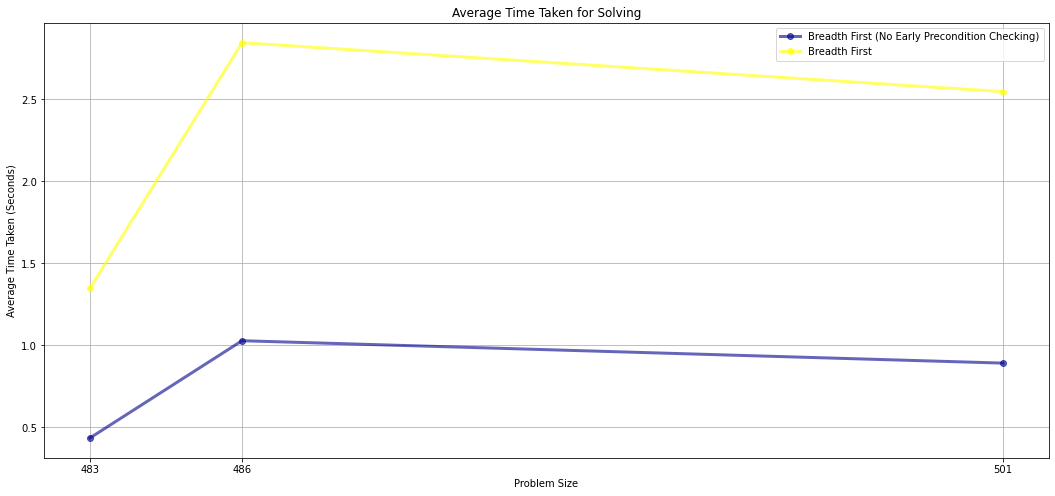

In [57]:
"""Create Graph"""
generate_graph(["Rover/p01.hddl", "Rover/p02.hddl", "Rover/p03.hddl"], ["Breadth First (No Early Precondition Checking)", "Breadth First"], ["darkblue", "yellow"], [
[breadth_first_no_early_precon_check_av_time["Rover/p01.hddl"],
 breadth_first_no_early_precon_check_av_time["Rover/p02.hddl"],
 breadth_first_no_early_precon_check_av_time["Rover/p03.hddl"]],
[breadth_first_early_precon_check_av_time["Rover/p01.hddl"],
 breadth_first_early_precon_check_av_time["Rover/p02.hddl"],
 breadth_first_early_precon_check_av_time["Rover/p03.hddl"]]
])

In [80]:
"""Stats test"""
# Get test times for rover p01
no_precon_check = breadth_first_no_early_precon_check[breadth_first_no_early_precon_check['example_name'] == "Rover/p01.hddl"]['time_taken']
precon_check = breadth_first_early_precon_check[breadth_first_early_precon_check['example_name'] == "Rover/p01.hddl"]['time_taken']

significant_difference_check(["Breadth First (No Early Precondition Checking)", "Breadth First"], no_precon_check, precon_check)

All data is normally distributed
Shapiro p-values: [0.22169914841651917, 0.4353247284889221]
Non-Normal Check (False denoted non-normal): [False, False]
3.859620553806911e-05


## Rover p4 -> p7 with and without early precon checking

## Rover p0 -> p3 breadth first with and without data pruning. Predicate distance to goal p0 -> p3 also

In [41]:
breadth_first_early_precon_check

,example_name,time_taken,search_models_created,serialised_actions_taken,serialised_state
0,Rover/p01.hddl,1.098345,2571,serialised_objects\Rover_p01hddl_Breadth_First...,serialised_objects\Rover_p01hddl_Breadth_First...
1,Rover/p01.hddl,1.518126,5142,serialised_objects\Rover_p01hddl_Breadth_First...,serialised_objects\Rover_p01hddl_Breadth_First...
2,Rover/p01.hddl,1.195930,7713,serialised_objects\Rover_p01hddl_Breadth_First...,serialised_objects\Rover_p01hddl_Breadth_First...
3,Rover/p01.hddl,1.692070,10284,serialised_objects\Rover_p01hddl_Breadth_First...,serialised_objects\Rover_p01hddl_Breadth_First...
4,Rover/p01.hddl,1.230000,12855,serialised_objects\Rover_p01hddl_Breadth_First...,serialised_objects\Rover_p01hddl_Breadth_First...
5,Rover/p02.hddl,2.855361,17516,serialised_objects\Rover_p02hddl_Breadth_First...,serialised_objects\Rover_p02hddl_Breadth_First...
6,Rover/p02.hddl,3.338921,22177,serialised_objects\Rover_p02hddl_Breadth_First...,serialised_objects\Rover_p02hddl_Breadth_First...
7,Rover/p02.hddl,2.625027,26838,serialised_objects\Rover_p02hddl_Breadth_First...,serialised_objects\Rover_p02hddl_Breadth_First...
8,Rover/p02.hddl,2.679398,31499,serialised_objects\Rover_p02hddl_Breadth_First...,serialised_objects\Rover_p02hddl_Breadth_First...
9,Rover/p02.hddl,2.726319,36160,serialised_objects\Rover_p02hddl_Breadth_First...,serialised_objects\Rover_p02hddl_Breadth_First...


In [47]:
"""Load data from breadth first"""
breadth_first_pruning_data_path = os.path.join(os.getcwd(), "Archive", "Rover", "Breadth_First_Operations_Pruning.csv")
breadth_first_pruning = pd.read_csv(breadth_first_pruning_data_path, sep=",")

breadth_first_pruning_av_time = average_time()
for example_name in breadth_first_pruning.example_name.unique():
    breadth_first_pruning_av_time.calculate_average_time(example_name, breadth_first_pruning[breadth_first_pruning['example_name'] == example_name]['time_taken'])

    breadth_first_pruning_av_time.calculate_average_model(example_name, breadth_first_pruning[breadth_first_pruning['example_name'] == example_name]['search_models_created'])

breadth_first_pruning

,example_name,time_taken,search_models_created,serialised_actions_taken,serialised_state
0,Rover/p01.hddl,0.218124,507,serialised_objects\Rover_p01hddl_Breadth_First...,serialised_objects\Rover_p01hddl_Breadth_First...
1,Rover/p01.hddl,0.463474,1014,serialised_objects\Rover_p01hddl_Breadth_First...,serialised_objects\Rover_p01hddl_Breadth_First...
2,Rover/p01.hddl,0.487561,1521,serialised_objects\Rover_p01hddl_Breadth_First...,serialised_objects\Rover_p01hddl_Breadth_First...
3,Rover/p01.hddl,0.253365,2028,serialised_objects\Rover_p01hddl_Breadth_First...,serialised_objects\Rover_p01hddl_Breadth_First...
4,Rover/p01.hddl,0.241992,2535,serialised_objects\Rover_p01hddl_Breadth_First...,serialised_objects\Rover_p01hddl_Breadth_First...
5,Rover/p02.hddl,0.327061,3352,serialised_objects\Rover_p02hddl_Breadth_First...,serialised_objects\Rover_p02hddl_Breadth_First...
6,Rover/p02.hddl,0.291050,4169,serialised_objects\Rover_p02hddl_Breadth_First...,serialised_objects\Rover_p02hddl_Breadth_First...
7,Rover/p02.hddl,0.318121,4986,serialised_objects\Rover_p02hddl_Breadth_First...,serialised_objects\Rover_p02hddl_Breadth_First...
8,Rover/p02.hddl,0.278855,5803,serialised_objects\Rover_p02hddl_Breadth_First...,serialised_objects\Rover_p02hddl_Breadth_First...
9,Rover/p02.hddl,0.305403,6620,serialised_objects\Rover_p02hddl_Breadth_First...,serialised_objects\Rover_p02hddl_Breadth_First...


In [44]:
"""Load data from Hamming Distance to goal"""
predicate_distance_to_goal_data_path = os.path.join(os.getcwd(), "Archive", "Rover", "Hamming_Distance.csv")
predicate_distance_to_goal = pd.read_csv(predicate_distance_to_goal_data_path, sep=",")

predicate_distance_to_goal_av_time = average_time()
for example_name in predicate_distance_to_goal.example_name.unique():
    predicate_distance_to_goal_av_time.calculate_average_time(example_name, predicate_distance_to_goal[predicate_distance_to_goal['example_name'] == example_name]['time_taken'])

    predicate_distance_to_goal_av_time.calculate_average_model(example_name, predicate_distance_to_goal[predicate_distance_to_goal['example_name'] == example_name]['search_models_created'])

predicate_distance_to_goal

,example_name,time_taken,search_models_created,serialised_actions_taken,serialised_state
0,Rover/p01.hddl,0.163832,216,serialised_objects\Rover_p01hddl_Hamming_Dista...,serialised_objects\Rover_p01hddl_Hamming_Dista...
1,Rover/p01.hddl,0.096767,432,serialised_objects\Rover_p01hddl_Hamming_Dista...,serialised_objects\Rover_p01hddl_Hamming_Dista...
2,Rover/p01.hddl,0.088313,648,serialised_objects\Rover_p01hddl_Hamming_Dista...,serialised_objects\Rover_p01hddl_Hamming_Dista...
3,Rover/p01.hddl,0.077604,864,serialised_objects\Rover_p01hddl_Hamming_Dista...,serialised_objects\Rover_p01hddl_Hamming_Dista...
4,Rover/p01.hddl,0.078070,1080,serialised_objects\Rover_p01hddl_Hamming_Dista...,serialised_objects\Rover_p01hddl_Hamming_Dista...
5,Rover/p02.hddl,0.165275,1493,serialised_objects\Rover_p02hddl_Hamming_Dista...,serialised_objects\Rover_p02hddl_Hamming_Dista...
6,Rover/p02.hddl,0.243970,1906,serialised_objects\Rover_p02hddl_Hamming_Dista...,serialised_objects\Rover_p02hddl_Hamming_Dista...
7,Rover/p02.hddl,0.277247,2319,serialised_objects\Rover_p02hddl_Hamming_Dista...,serialised_objects\Rover_p02hddl_Hamming_Dista...
8,Rover/p02.hddl,0.422586,2732,serialised_objects\Rover_p02hddl_Hamming_Dista...,serialised_objects\Rover_p02hddl_Hamming_Dista...
9,Rover/p02.hddl,0.278713,3145,serialised_objects\Rover_p02hddl_Hamming_Dista...,serialised_objects\Rover_p02hddl_Hamming_Dista...


[[1.3468943119049073, 2.8450050354003906, 2.5467882633209227], [0.33290305137634274, 0.30409789085388184, 0.5028377532958984], [0.1009172916412353, 0.27755808830261225, 0.3271346092224121]]


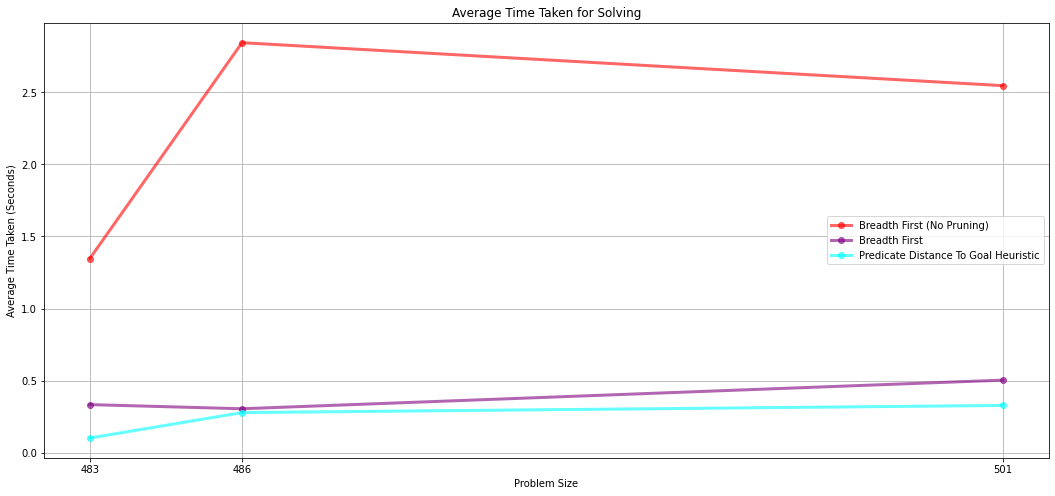

In [48]:
"""Create Graph"""
generate_graph(["Rover/p01.hddl", "Rover/p02.hddl", "Rover/p03.hddl"], ["Breadth First (No Pruning)", "Breadth First", "Predicate Distance To Goal Heuristic"], ["red", "purple", "aqua"],
[
    [breadth_first_early_precon_check_av_time["Rover/p01.hddl"],
     breadth_first_early_precon_check_av_time["Rover/p02.hddl"],
     breadth_first_early_precon_check_av_time["Rover/p03.hddl"]],
    [breadth_first_pruning_av_time["Rover/p01.hddl"],
     breadth_first_pruning_av_time["Rover/p02.hddl"],
     breadth_first_pruning_av_time["Rover/p03.hddl"]],
    [predicate_distance_to_goal_av_time["Rover/p01.hddl"],
     predicate_distance_to_goal_av_time["Rover/p02.hddl"],
     predicate_distance_to_goal_av_time["Rover/p03.hddl"]]
])

In [ ]:
"""Stats tests"""

## Rover p04 pruning and predicate_distance
For this test, the breadth first non-pruning search strategy was run for 2 hours and was not able to produce a result

In [49]:
"""Create Graph"""
generate_graph(["Rover/p01.hddl", "Rover/p02.hddl", "Rover/p03.hddl", "Rover/p04.hddl"],
               ["Breadth First", "Predicate Distance To Goal Heuristic"], ["purple", "aqua"],
               [
                   [breadth_first_pruning_av_time["Rover/p01.hddl"],
                    breadth_first_pruning_av_time["Rover/p02.hddl"],
                    breadth_first_pruning_av_time["Rover/p03.hddl"],
                    breadth_first_pruning_av_time["Rover/p04.hddl"]],
                   [predicate_distance_to_goal_av_time["Rover/p01.hddl"],
                    predicate_distance_to_goal_av_time["Rover/p02.hddl"],
                    predicate_distance_to_goal_av_time["Rover/p03.hddl"],
                    predicate_distance_to_goal_av_time["Rover/p04.hddl"]]
               ])

KeyError: 'Rover/p04.hddl'

## Rover p0 -> p7 predicate distance to goal

[[0.1009172916412353, 0.27755808830261225, 0.3271346092224121, 10.867805528640748, 23.9460120677948, 33.44564228057861, 123.3193585395813]]


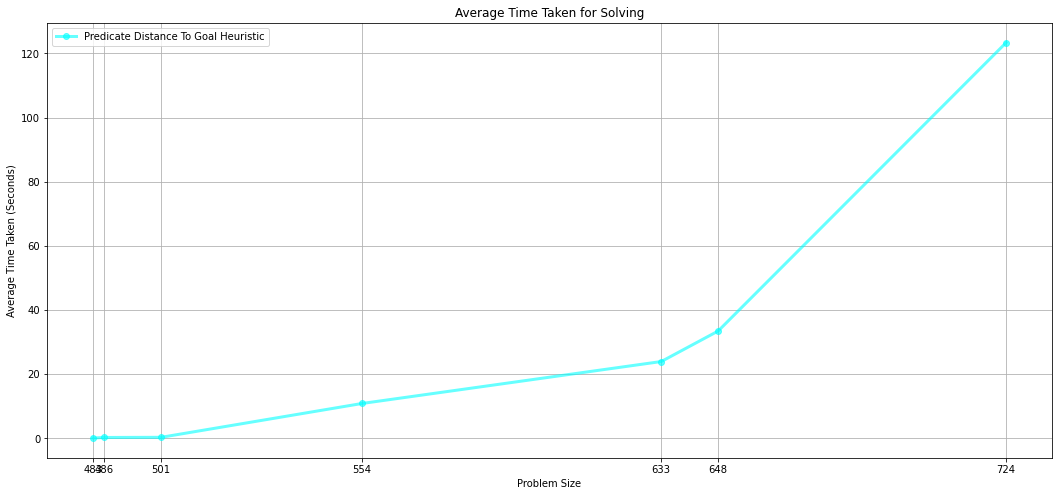

In [50]:
"""Create Graph"""
generate_graph(["Rover/p01.hddl", "Rover/p02.hddl", "Rover/p03.hddl", "Rover/p04.hddl", "Rover/p05.hddl",
                "Rover/p06.hddl", "Rover/p07.hddl"],
               ["Predicate Distance To Goal Heuristic"], ["aqua"],
               [
                   [predicate_distance_to_goal_av_time["Rover/p01.hddl"],
                    predicate_distance_to_goal_av_time["Rover/p02.hddl"],
                    predicate_distance_to_goal_av_time["Rover/p03.hddl"],
                    predicate_distance_to_goal_av_time["Rover/p04.hddl"],
                    predicate_distance_to_goal_av_time["Rover/p05.hddl"],
                    predicate_distance_to_goal_av_time["Rover/p06.hddl"],
                    predicate_distance_to_goal_av_time["Rover/p07.hddl"]]
               ])

# Graph number of models created during search

## Rover p0 -> p3. Breadth first, breadth first with pruning, predicate distance to goal

[[7713, 26838, 49138], [1521, 4986, 9314], [648, 2319, 4240]]


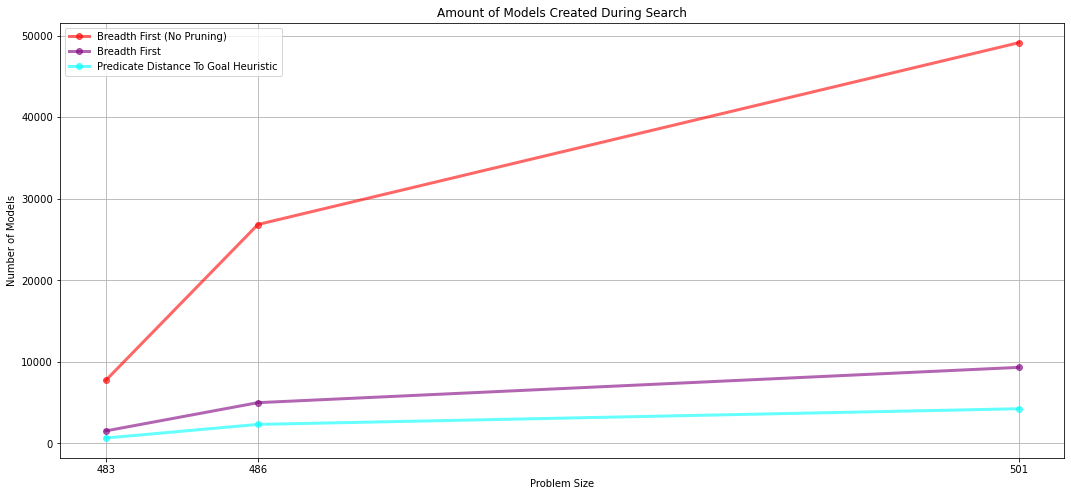

In [51]:
"""Create Graph"""
generate_graph(["Rover/p01.hddl", "Rover/p02.hddl", "Rover/p03.hddl"], ["Breadth First (No Pruning)", "Breadth First", "Predicate Distance To Goal Heuristic"], ["red", "purple", "aqua"],
               [
                   [breadth_first_early_precon_check_av_time.get_num_models("Rover/p01.hddl"),
                    breadth_first_early_precon_check_av_time.get_num_models("Rover/p02.hddl"),
                    breadth_first_early_precon_check_av_time.get_num_models("Rover/p03.hddl")],
                   [breadth_first_pruning_av_time.get_num_models("Rover/p01.hddl"),
                    breadth_first_pruning_av_time.get_num_models("Rover/p02.hddl"),
                    breadth_first_pruning_av_time.get_num_models("Rover/p03.hddl")],
                   [predicate_distance_to_goal_av_time.get_num_models("Rover/p01.hddl"),
                    predicate_distance_to_goal_av_time.get_num_models("Rover/p02.hddl"),
                    predicate_distance_to_goal_av_time.get_num_models("Rover/p03.hddl")]
               ], "Amount of Models Created During Search", "Number of Models")

# Area for checking serialised files

In [ ]:
file_name = predicate_distance_to_goal.iloc[0]['serialised_actions_taken']
actions_taken = load_pickled_ob(file_name)
display_actions_taken(actions_taken)

In [ ]:
file_name = predicate_distance_to_goal.iloc[0]['serialised_state']
final_state = load_pickled_ob(file_name)
display_final_state(final_state)